<a href="https://colab.research.google.com/github/CDFire/ProjectsInAI-ML/blob/main/HW6/Homework6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1

In [2]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [3]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00


In [4]:
pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.2
    Uninstalling transformers-4.50.2:
      Successfully uninstalled transformers-4.50.2


In [1]:
import numpy as np
from transformers import BartForConditionalGeneration, BartTokenizerFast, Trainer, TrainingArguments
import evaluate
from datasets import load_dataset
import os

In [17]:
dataset = load_dataset("cnn_dailymail", "3.0.0", streaming=True)

train_stream = dataset["train"]

small_train_dataset = train_stream.take(100)
small_test_dataset = train_stream.skip(100).take(20)

print("Created small train and test streaming datasets.")

small_train_list = list(small_train_dataset)
small_test_list = list(small_test_dataset)

print(f"Small train dataset has {len(small_train_list)} examples.")
print(f"Small test dataset has {len(small_test_list)} examples.")

print("First training example:", small_train_list[0])

Created small train and test streaming datasets.
Small train dataset has 100 examples.
Small test dataset has 20 examples.
First training example: {'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in

In [18]:
model_name = "facebook/bart-base"
tokenizer = BartTokenizerFast.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=1024,
        truncation=True,
        text_target=examples["highlights"],
        max_target_length=128,
        truncation_target=True
    )
    return model_inputs

In [19]:
train_dataset = small_train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["article", "highlights", "id"]
)
test_dataset = small_test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["article", "highlights", "id"]
)

In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    run_name="my_finetuning_run",
    report_to=[],
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    dataloader_num_workers=2,
    gradient_accumulation_steps=1,
    max_steps=100
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9e636a3c59ef559b547b269cf2fd31685cf464e1089d44230088b5a968abbff1
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [21]:
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")

In [22]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # compute ROUGE scores
    rouge_result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # compute BLEU scores
    bleu_result = bleu_metric.compute(
        predictions=[pred.split() for pred in decoded_preds],
        references=[[ref.split()] for ref in decoded_labels]
    )

    result = {
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "bleu": bleu_result["bleu"],
    }
    return result

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

No matter what I did for task one (decreasing dataset size, different batch sizes and techniques, turning on streaming for loading the dataset) Google Colab ran out of RAM on CPU or ran out of memory when ran on the GPU. I spent so much time trying to get this to work on Colab but I just couldn't get it to finish without running out of memory. Because of this, I obviously don't have results to discuss, so I am going to discuss my understanding of the impact of the hyperperameters and the choice of LLM.

The learning rate dictates how quickly the model adjusts its weights during training. A high learning rate may lead to rapid convergence but risks overshooting the minima, resulting in instability or divergence. Conversely, a too-low learning rate can slow down convergence, potentially trapping the model in local minima.

The batch size influences the gradient estimation during optimization. Larger batches provide a more stable and representative gradient, reducing variance but potentially leading to less frequent updates, which might affect generalization. Smaller batches introduce more noise, which can sometimes help the model escape shallow local minima and improve generalization.

Regularization techniques are essential to avoid overfitting. They help the model generalize better on unseen data by penalizing complexity. For instance, dropout randomly deactivates a subset of neurons during training, which forces the model to develop redundant representations and reduces reliance on any single pathway.

Number of Layers and hidden units determine the capacity of the model. A deeper or wider network can capture more complex patterns but also increases the risk of overfitting and computational costs.

The choice of LLM inherently influences the outcomes in several ways. Different LLMs are pretrained on various datasets and may have different objectives during pretraining. This means that the model’s internal representations and understanding of language can vary significantly, affecting performance on downstream tasks. In adition, LLMs come with built-in assumptions based on their architecture. For example, transformer-based models are excellent at capturing long-range dependencies, which might be beneficial for certain tasks, while other architectures may have different strengths and limitations. An LLM’s performance in a specific task can also depend on how well it adapts during fine-tuning. Some models might be more robust or easier to fine-tune, which could lead to better performance.

#Task 2

A real-world application that can be formulated as a Markov Decision Process is autonomous driving. In this setting, an autonomous vehicle must make a series of decisions like accelerating, braking, turning, etc. to safely and efficiently navigate through traffic and reach its destination.

The state space includes all the relevant information about the car and its environment at a given time. This includes the car’s position and velocity, nearby obstacles or vehicles, lane markings, traffic light status, and road conditions. The action space consists of the possible maneuvers the car can perform such as changing lanes, accelerating, decelerating, or making turns. The transition model defines how the car’s actions change its state over time like accelerating increases speed, while turning changes direction. These transitions can also depend on stochastic elements like the behavior of other drivers or sudden changes in the environment. The reward function reflects the desirability of outcomes. For example, the agent may receive positive rewards for staying in the correct lane, obeying traffic laws, and progressing toward the destination, and negative rewards for unsafe maneuvers, collisions, or going off-road.

This formulation allows the problem of autonomous driving to be approached as an optimization task, where the agent learns a policy that maximizes cumulative reward, leading to safe and efficient driving behavior over time.

#Task 3

Problem: Treatment Policy Optimization for Sepsis in ICU

Managing sepsis is a complex decision-making problem. Physicians must continuously decide on medication dosages, like vasopressors and IV fluids, based on the evolving state of the patient. The challenge lies in accounting for long-term effects of treatment—some interventions may help in the short term but harm the patient later. Traditional supervised learning methods struggle with this sequential, decision-dependent nature of the problem. Reinforcement learning, on the other hand, can model these treatment decisions as a sequential decision-making process and learn an optimal policy that improves patient outcomes over time.

State space: Includes patient vitals, lab results, and history of interventions—such as heart rate, blood pressure, white blood cell count, and administered medications.

Action space: Consists of discrete combinations of medical interventions, like different dosages of vasopressors and IV fluids.

Rewards: The agent is rewarded for positive patient outcome, like survival and stability in vitals, and penalized for adverse outcomes or complications.

.

**Open-Source Project:** “Deep Reinforcement Learning for Sepsis Treatment”

One of the most well-known projects in this area is by researchers at MIT and Harvard. It is publicly available on GitHub at https://github.com/matthieukomorowski/AI_Clinician and uses the MIMIC-III dataset—a rich database of de-identified ICU patient records.

The objective of the project is to train a reinforcement learning agent to recommend treatment policies for sepsis patients in the ICU. The researchers modeled the problem as an MDP where the agent observes patient state (from historical records) and recommends actions (drug dosages). The model used fitted Q-iteration to learn the optimal policy offline from historical data. Patient states were clustered into a discrete space using k-means, and actions were discretized combinations of IV fluid and vasopressor dosages. The learned policy was then compared with actual clinician decisions. The RL agent’s treatment policy, in many cases, aligned with best-practice care but also suggested more conservative medication use in some situations. When evaluated retrospectively, patients who received treatments closer to the AI’s policy showed improved outcomes. This project demonstrated that reinforcement learning could potentially assist or augment clinical decision-making. While it’s not used in production due to ethical and safety concerns, it remains a significant step toward intelligent clinical decision support systems.

#Task 4

In [ ]:
import random

In [ ]:
class TicTacToe:
    def __init__(self):
        self.board = [' ' for _ in range(9)]
        self.current_winner = None

    def reset(self):
        self.board = [' ' for _ in range(9)]
        self.current_winner = None
        return self.get_state()

    def get_state(self):
        return tuple(self.board)

    def available_moves(self):
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def make_move(self, square, letter):
        if self.board[square] == ' ':
            self.board[square] = letter
            if self.winner(square, letter):
                self.current_winner = letter
            return True
        return False

    def winner(self, square, letter):
        row_ind = square // 3
        row = self.board[row_ind*3:(row_ind+1)*3]
        if all([s == letter for s in row]):
            return True
        col_ind = square % 3
        column = [self.board[col_ind+i*3] for i in range(3)]
        if all([s == letter for s in column]):
            return True
        if square % 2 == 0:
            diagonal1 = [self.board[i] for i in [0, 4, 8]]
            if all([s == letter for s in diagonal1]):
                return True
            diagonal2 = [self.board[i] for i in [2, 4, 6]]
            if all([s == letter for s in diagonal2]):
                return True
        return False

    def is_draw(self):
        return ' ' not in self.board and self.current_winner is None

    def render(self):
        for i in range(3):
            print('| ' + ' | '.join(self.board[i*3:(i+1)*3]) + ' |')

In [ ]:
class QLearningAgent:
    def __init__(self, letter, alpha=0.5, gamma=0.9, epsilon=0.2):
        self.letter = letter
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q = {}

    def get_q(self, state, action):
        return self.q.get((state, action), 0.0)

    def choose_action(self, state, available_moves):
        if random.random() < self.epsilon:
            return random.choice(available_moves)
        qs = [self.get_q(state, a) for a in available_moves]
        max_q = max(qs)
        max_actions = [a for a, q in zip(available_moves, qs) if q == max_q]
        return random.choice(max_actions)

    def update(self, state, action, reward, next_state, next_available_moves, done):
        max_q_next = 0.0
        if not done and next_available_moves:
            qs_next = [self.get_q(next_state, a) for a in next_available_moves]
            max_q_next = max(qs_next)
        old_q = self.get_q(state, action)
        new_q = old_q + self.alpha * (reward + self.gamma * max_q_next - old_q)
        self.q[(state, action)] = new_q

In [ ]:
class RandomAgent:
    def __init__(self, letter):
        self.letter = letter

    def choose_action(self, state, available_moves):
        return random.choice(available_moves)

In [ ]:
def play_game(agent_x, agent_o, env, training=True):
    state = env.reset()
    current_agent = agent_x
    while True:
        available = env.available_moves()
        action = current_agent.choose_action(state, available)
        env.make_move(action, current_agent.letter)
        next_state = env.get_state()
        available_next = env.available_moves()
        if env.current_winner == current_agent.letter:
            reward = 1 if current_agent.letter == 'X' else -1
            if training and isinstance(current_agent, QLearningAgent):
                current_agent.update(state, action, reward, next_state, available_next, True)
            return current_agent.letter
        elif env.is_draw():
            if training and isinstance(current_agent, QLearningAgent):
                current_agent.update(state, action, 0, next_state, available_next, True)
            return 'Draw'
        if training and isinstance(current_agent, QLearningAgent):
            current_agent.update(state, action, 0, next_state, available_next, False)
        state = next_state
        current_agent = agent_o if current_agent == agent_x else agent_x

In [ ]:
def simulate_games(num_games, agent_x, agent_o, env, training=True):
    results = {'X': 0, 'O': 0, 'Draw': 0}
    for _ in range(num_games):
        result = play_game(agent_x, agent_o, env, training)
        results[result] += 1
    return results

In [ ]:
env = TicTacToe()
q_agent = QLearningAgent(letter='X', epsilon=0.2)
random_agent = RandomAgent(letter='O')

num_training_games = 100000
train_results = simulate_games(num_training_games, q_agent, random_agent, env, training=True)
print("Training results over {} games:".format(num_training_games))
print(train_results)

Training results over 100000 games:
{'X': 77381, 'O': 14968, 'Draw': 7651}


In [ ]:
q_agent.epsilon = 0.0
num_eval_games = 1000
eval_results = simulate_games(num_eval_games, q_agent, random_agent, env, training=False)
print("\nEvaluation results over {} games:".format(num_eval_games))
print(eval_results)


Evaluation results over 1000 games:
{'X': 816, 'O': 127, 'Draw': 57}


In [ ]:
print("\nDemonstration games:")
for _ in range(3):
    env.reset()
    state = env.get_state()
    current_agent = q_agent  # 'X' starts
    while True:
        available = env.available_moves()
        action = current_agent.choose_action(state, available)
        env.make_move(action, current_agent.letter)
        state = env.get_state()
        if env.current_winner or env.is_draw():
            env.render()
            if env.current_winner:
                print("Result: Winner is", env.current_winner)
            else:
                print("Result: Draw")
            print("--------------------")
            break
        current_agent = random_agent if current_agent == q_agent else q_agent


Demonstration games:
|   |   | X |
| O | X |   |
| X |   | O |
Result: Winner is X
--------------------
| X |   |   |
| X | O |   |
| X | O |   |
Result: Winner is X
--------------------
|   |   | O |
|   |   | O |
| X | X | X |
Result: Winner is X
--------------------


The game state is defined as a tuple representing the 9 board positions (each can be 'X', 'O', or ' '). The actions are the indices (0–8) corresponding to the available empty squares on the board. When an agent takes an action, the environment updates the board accordingly and checks for terminal conditions (win or draw). Although the transitions are deterministic (given a move, the board updates in a fixed way), the opponent’s moves introduce uncertainty. The agent receives a reward of +1 for winning, –1 for losing, and 0 for draws or intermediate steps.

My evaluation metric is the win rate of the Q‑learning agent when playing as “X” against a random agent. After training, epsilon is ser to 0 and then the agent is evaluated over 1,000 games, recording the number of wins, losses, and draws. The expectation is that as training progresses, the win rate will improve, reflecting a more effective policy.

#Task 5

In [5]:
pip install numpy==1.24.0

  Using cached numpy-1.24.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.0 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.24.0 which is incompatible.
seaborn 0.13.2 requires numpy!=1.24.0,>=1.20, but you have numpy 1.24.0 which is incompatible.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.0 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.0 which is incompatible.
blosc2 3.2.1 requires numpy>=

In [1]:
pip install --force-reinstall scikit-surprise

  Using cached scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
  Attempting uninstall: scikit-surprise
    Found existing installation: scikit-s

In [1]:
import numpy as np
if not hasattr(np, 'bool'):
    np.bool = bool
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from numpy.linalg import solve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import random

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

<ipython-input-1-840c1747fff6>:2: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(np, 'bool'):


In [4]:
data_path = "ml-100k/u.data"
column_names = ["user_id", "item_id", "rating", "timestamp"]
df = pd.read_csv(data_path, sep='\t', names=column_names)

df['user_id'] = df['user_id'].astype(int)
df['item_id'] = df['item_id'].astype(int)
df['rating'] = df['rating'].astype(float)
df.drop("timestamp", axis=1, inplace=True)

print("Data head:")
print(df.head())

Data head:
   user_id  item_id  rating
0      196      242     3.0
1      186      302     3.0
2       22      377     1.0
3      244       51     2.0
4      166      346     1.0


<ipython-input-5-79c4450cd730>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


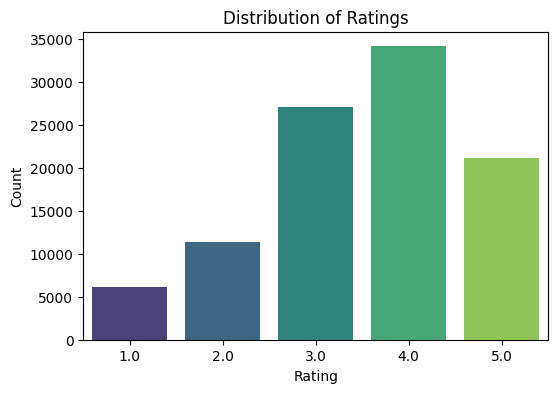

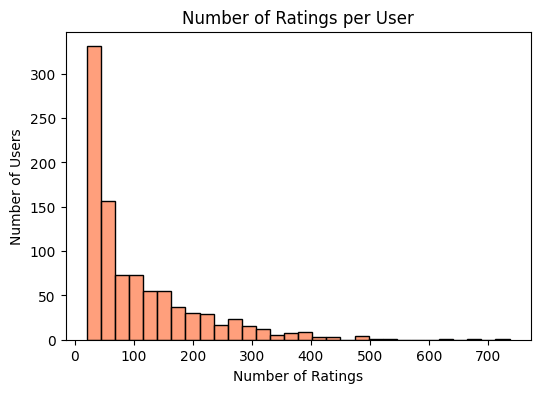

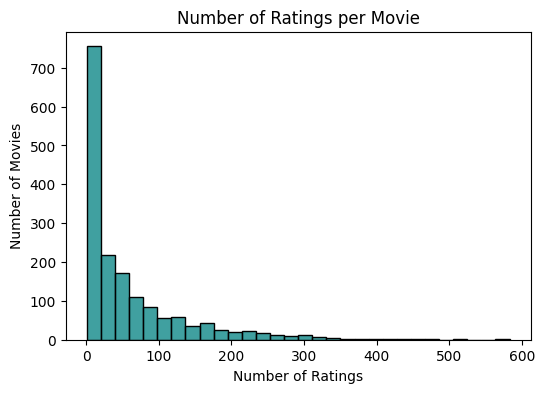

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

ratings_per_user = df.groupby('user_id').size()
plt.figure(figsize=(6,4))
sns.histplot(ratings_per_user, bins=30, kde=False, color='coral')
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

ratings_per_movie = df.groupby('item_id').size()
plt.figure(figsize=(6,4))
sns.histplot(ratings_per_movie, bins=30, kde=False, color='teal')
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.show()

In [6]:
user_item_matrix = df.pivot(index='user_id', columns='item_id', values='rating')
print("User-Item Matrix shape:", user_item_matrix.shape)

User-Item Matrix shape: (943, 1682)


In [11]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd_model = SVD(random_state=42)
svd_model.fit(trainset)

predictions = svd_model.test(testset)

svd_rmse = accuracy.rmse(predictions, verbose=False)
svd_mae = accuracy.mae(predictions, verbose=False)

print(f"SVD Model -> RMSE: {svd_rmse:.4f}, MAE: {svd_mae:.4f}")

SVD Model -> RMSE: 0.9352, MAE: 0.7375


In [12]:
R = user_item_matrix.fillna(0).values
num_users, num_items = R.shape

num_factors = 20
reg = 0.1
num_iters = 15

U = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
V = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))

In [13]:
def als_train(R, U, V, reg, num_iters):
    num_users, num_items = R.shape
    for it in range(num_iters):
        for u in range(num_users):
            idx = R[u, :] > 0
            V_i = V[idx, :]
            R_u = R[u, idx]
            if V_i.shape[0] == 0:
                continue
            A = V_i.T.dot(V_i) + reg * np.eye(num_factors)
            b = V_i.T.dot(R_u)
            U[u, :] = solve(A, b)

        for i in range(num_items):
            idx = R[:, i] > 0
            U_u = U[idx, :]
            R_i = R[idx, i]
            if U_u.shape[0] == 0:
                continue
            A = U_u.T.dot(U_u) + reg * np.eye(num_factors)
            b = U_u.T.dot(R_i)
            V[i, :] = solve(A, b)
        pred = U.dot(V.T)
        mse = np.sum(((R - pred)[R > 0])**2) / np.sum(R > 0)
        print(f"Iteration {it+1}/{num_iters}, MSE: {mse:.4f}")
    return U, V

In [14]:
def train_test_split_matrix(R, test_ratio=0.2):
    R_train = R.copy()
    test_data = []
    observed = np.argwhere(R > 0)
    n_test = int(len(observed) * test_ratio)
    test_indices = observed[np.random.choice(len(observed), size=n_test, replace=False)]

    for u, i in test_indices:
        test_data.append((u, i, R[u, i]))
        R_train[u, i] = 0
    return R_train, test_data

In [15]:
R_train, test_data = train_test_split_matrix(R, test_ratio=0.2)

U = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
V = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))

print("\nTraining ALS model:")
U, V = als_train(R_train, U, V, reg, num_iters)

preds = []
actuals = []
pred_matrix = U.dot(V.T)
for u, i, actual in test_data:
    preds.append(pred_matrix[u, i])
    actuals.append(actual)

als_rmse = sqrt(mean_squared_error(actuals, preds))
als_mae = mean_absolute_error(actuals, preds)
print(f"\nALS Model -> RMSE: {als_rmse:.4f}, MAE: {als_mae:.4f}")


Training ALS model:
Iteration 1/15, MSE: 2.1842
Iteration 2/15, MSE: 0.4416
Iteration 3/15, MSE: 0.3518
Iteration 4/15, MSE: 0.3162
Iteration 5/15, MSE: 0.2965
Iteration 6/15, MSE: 0.2837
Iteration 7/15, MSE: 0.2744
Iteration 8/15, MSE: 0.2674
Iteration 9/15, MSE: 0.2619
Iteration 10/15, MSE: 0.2574
Iteration 11/15, MSE: 0.2538
Iteration 12/15, MSE: 0.2507
Iteration 13/15, MSE: 0.2481
Iteration 14/15, MSE: 0.2458
Iteration 15/15, MSE: 0.2438

ALS Model -> RMSE: 1.4457, MAE: 1.0469


SVD Model (Matrix Factorization):

	•	RMSE: 0.9352
	•	MAE: 0.7375

ALS Model (Alternating Least Squares):

	•	RMSE: 1.4457
	•	MAE: 1.0469

Lower RMSE and MAE values indicate that the predictions are, on average, closer to the actual ratings. The SVD model has lower RMSE and MAE than the ALS model. This suggests that, on this dataset the SVD model’s predictions are more accurate. The matrix factorization approach implemented via SVD captures the underlying user-item interactions better than the ALS implementation. Because RMSE penalizes larger errors more heavily than MAE, the fact that both metrics are lower for the SVD model reinforces the conclusion that it not only has a lower average error but also fewer large prediction errors.

References

	•	Herlocker, J. L., Konstan, J. A., Terveen, L. G., & Riedl, J. T. (2004). Evaluating Collaborative Filtering Recommender Systems. https://dl.acm.org/doi/10.1145/963770.963772
	•	Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix Factorization Techniques for Recommender Systems. https://ieeexplore.ieee.org/document/5197422
	•	Hu, Y., Koren, Y., & Volinsky, C. (2008). Collaborative Filtering for Implicit Feedback Datasets. https://ieeexplore.ieee.org/document/4781121
